# Read in the data

In [1]:
import pandas as pd
import numpy
import re
pd.set_option('display.max_columns', 500)

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

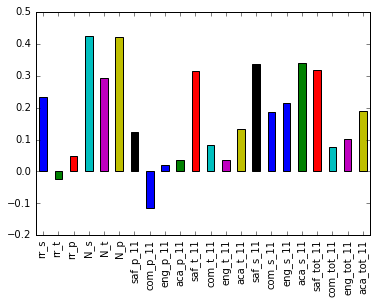

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
combined.corr()['sat_score'][survey_fields].plot.bar()

There are the top 2 correlations survey: N_s, N_p. N_s represents number of student respondents and N_p represents number of parent respondents. I would say that if more the students and the parents of the school are active in the survey, generaly higher the sat score they get. 
<br>
<br>
rr_t and com_p_11 have negative correlations. rr_t represents teacher response rate and com_p_11 represents communication score based on parent responses. Meaning a school with higher teacher response rate generaly has lower sat avg score.
<br>
<br>
saf_t_11 represents safty and respect total score based on teacher responses.
saf_s_11 represents safety and Respect score based on student responses.

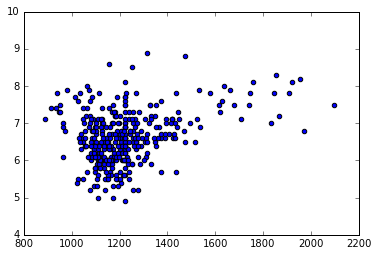

In [13]:
plt.scatter(combined['sat_score'],combined['saf_s_11'])

I can not really see a strong correlations between these two columns. However, there is a concentrated area where sat score is between 1000 and 1400 and saf_s_11 between 5 and 7.5. The graph is weakly correlated as I can see a weak adjacent line.

# Safety by geographic area plot:

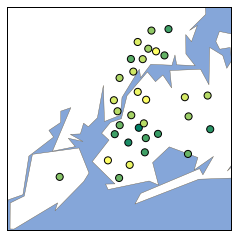

In [14]:
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True,c=districts["saf_s_11"], cmap="summer")
plt.show()


Manhaton has their safty sore according to student in school.

# Racial Vs SAT score analysis

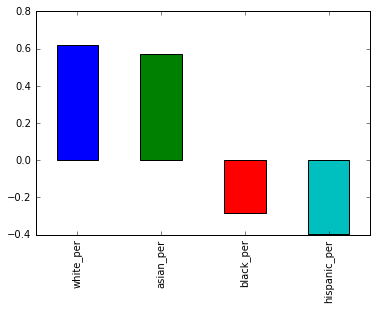

In [15]:
racial = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][racial].plot.bar()

School with higher race of white and asian generally has higher sat score

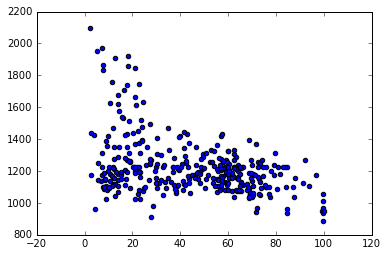

In [16]:
plt.scatter(combined['hispanic_per'],combined['sat_score'])

Almost negative correltion. Schools with higher hispanic percentage have lower sat score.

In [18]:
most_hisp_school = combined[combined['hispanic_per']>95]
#print(most_hisp_school)

In [20]:
hist10 = combined[combined['hispanic_per']<10]
hist_10_1800 = hist10[hist10['sat_score']>1800]
#print(hist_10_1800)

# Gender Vs SAT score analysis

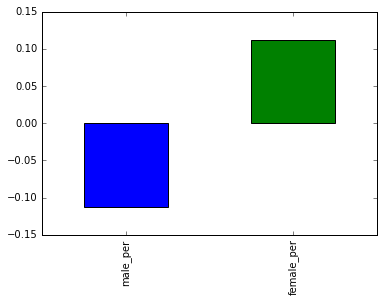

In [21]:
gender = ['male_per','female_per']
combined.corr()['sat_score'][gender].plot.bar()

Both genders have weak correlation with sat score. However, a school with high percentage of female with have slight higher SAT score.

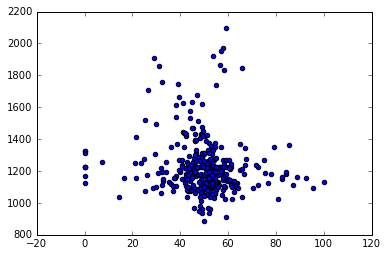

In [22]:
plt.scatter(combined['male_per'],combined['sat_score'])

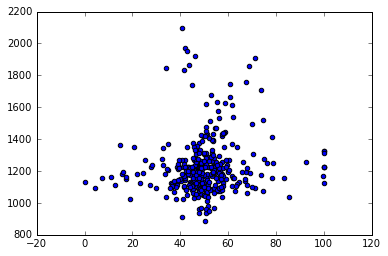

In [23]:
plt.scatter(combined['female_per'],combined['sat_score'])

I find out that the most concentrated part is around 40 to 60 percent of female. With some school with 40% female gets high score in SAT. I think thats why female has slight higher correlation then male does.

In [25]:
female_60 = combined[combined['female_per']>60]
female_60_1700 = female_60[female_60['sat_score']>1700]
#print(female_60_1700)

   As a partnership between Bard College and various local public school systems, the BHSEC model allows highly motivated and scholastically strong students to begin their college studies two years early, graduating with a Bard College Associate in Arts degree in addition to their high school diploma. Students complete their high school studies in the ninth and tenth grades, after which point they begin taking credit-bearing college courses under the same roof. 
   Eleanor Roosevelt High School (ERHS), is a Maryland public magnet high school specializing in science, mathematics, technology, and engineering. The school was established in 1976 at its current location in Greenbelt, Maryland and is part of the Prince George's County Public Schools system. It was the first high school named for former first lady Eleanor Roosevelt.
   The Beacon School (also called Beacon High School) is a selective college-preparatory public high school in the Hell's Kitchen area of Manhattan in New York City, near Times Square and the Theater District. Beacon's curriculum exceeds the standards set by the New York State Regents, and as a member of the New York Performance Standards Consortium, its students are exempt from taking most Regents exams.

From the description from Wiki, I can say that a lot of these high schools are college preparational. Thus, the school will highly concentrated in helping student to achieve higher SAT score.

# Correlation between AP score and SAT score analysis

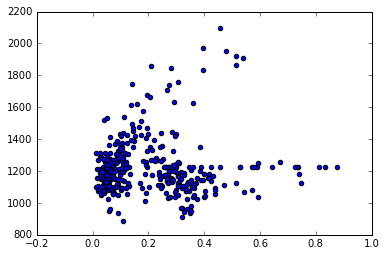

In [26]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
plt.scatter(combined['ap_per'],combined['sat_score'])

The plot is showing that a school with a higher the percentage of AP task taker, the higher the SAT avg score the school will have. However, at an extreme, some schools have about 80 - 90 percent of AP taker does not score well on SAT exam. Maybe the student has a higher AP score than their SAT score.

# Correlation between class size and SAT score

In [27]:
combined.corr()['AVERAGE CLASS SIZE']['sat_score']

0.3810143308095523

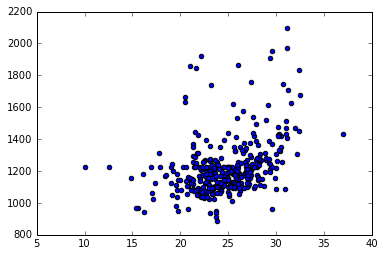

In [28]:
plt.scatter(combined['AVERAGE CLASS SIZE'],combined['sat_score'])

There is a weak correlation between avg class size and SAT score. I am suprised that this plot is indicating that a school with relative larger class will have a higher SAT score. 

# Best neighborhood for high school

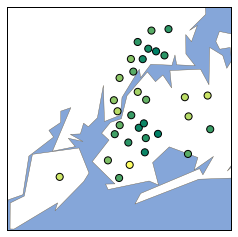

In [29]:
# In this case, I would say that a school with higher avg SAT is generally better.Therfore I would use SAT score to indicate the district.
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True,c=districts["sat_score"], cmap="summer")
plt.show()

In [30]:
best_neighborhoods = districts[districts['sat_score']>1300]
best_neighborhoods

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,schoolyear,fl_percent,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon,ap_per
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,5.148538,22.675415,18.798392,26.553044,0.0,20112012.0,0.0,58.983333,668.500000,42.166667,10.000000,82.000000,17.083333,134.500000,17.516667,125.500000,22.333333,214.833333,40.733333,186.000000,18.450000,328.166667,50.050000,340.333333,49.950000,76.500000,85.333333,33.166667,525.368056,38.500000,239.166667,8.233333,7.800000,7.683333,8.016667,7.066667,6.233333,6.700000,7.500000,6.768611,6.165787,6.736713,7.446898,7.433333,6.816667,7.116667,7.683333,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377,0.192551
21,22,473.500000,502.750000,474.250000,1450.500000,391.007212,614.509615,370.362500,580.250000,22.0,495.279369,15.777391,30.077636,22.509675,33.464740,0.0,20112012.0,0.0,44.225000,2142.500000,138.250000,4.400000,166.250000,6.650000,507.750000,17.975000,622.250000,35.100000,271.000000,12.350000,732.000000,33.975000,1015.750000,44.300000,1126.750000,55.700000,90.250000,87.500000,48.750000,1887.250000,89.500000,1106.250000,8.300000,7.325000,7.525000,7.775000,8.175000,7.400000,7.600000,8.200000,7.025000,6.050000,6.775000,7.500000,7.850000,6.900000,7.300000,7.850000,12.0,12.0,11223.000000,2149.000000,2.250000,0.0,0.0,0.0,40.618285,-73.952288,0.215706
24,25,437.250000,483.500000,436.250000,1357.000000,205.260817,279.889423,174.793750,268.733871,25.0,280.576007,9.990385,27.106270,21.213189,31.371220,0.0,20112012.0,0.0,52.950000,1356.750000,257.500000,19.737500,136.750000,9.975000,465.250000,40.600000,240.375000,13.062500,494.000000,29.237500,148.875000,16.537500,669.500000,48.500000,687.250000,51.500000,87.000000,78.500000,37.625000,1028.250000,56.000000,370.875000,8.175000,7.537500,7.412500,7.687500,7.487500,6.825000,7.200000,7.712500,6.912500,6.150000,6.712500,7.400000,7.525000,6.837500,7.112500,7.612500,12.0,12.0,11361.000000,1288.875000,1.875000,0.0,0.0,0.0,40.745414,-73.815558,0.205119
25,26,445.200000,487.600000,444.800000,1377.600000,410.605769,632.407692,392.090000,825.600000,26.0,595.953216,19.240117,29.971140,20.315789,33.554327,0.0,20112012.0,0.0,43.800000,2991.600000,248.600000,7.480000,350.000000,11.960000,1259.200000,38.140000,676.400000,28.420000,604.800000,19.380000,432.400000,13.420000,1475.000000,49.220000,1516.600000,50.780000,67.000000,83.400000,23.800000,1930.800000,129.800000,684.200000,7.720000,6.980000,7.220000,7.260000,7.000000,6.580000,6.840000,7.260000,6.760000,6.060000,6.660000,7.380000,7.140000,6.540000,6.900000,7.300000,12.0,12.0,11388.600000,2837.400000,4.600000,0.0,0.0,0.0,40.748507,-73.759176,0.124673
27,28,445.941655,465.997286,435.908005,1347.846947,182.010490,273.559441,175.336364,351.214076,28.0,255.381164,8.719058,26.770807,21.349816,30.172038,0.0,20112012.0,0.0,53.790909,1210.636364,87.363636,4.963636,123.454545,9.827273,403.727273,31.345455,343.727273,37.509091,283.454545,19.954545,165.636364,9.400000,590.363636,45.863636,620.272727,54.136364,85.090909,85.545455,40.545455,872.545455,54.727273,362.636364,8.172727,7.590909,7.472727,7.781818,7.600000,7.145455,7.363636,7.972727,6.627273,6.081818,6.618182,7.454545,7.463636,6.936364,7.145

From the list we see above, these school district are good: 01, 22, 25, 26, 28, 30, 31.